# This is for Reconciling results between Tom Marsik and I

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
# import matplotlib pyplot commands
from matplotlib.pyplot import *
# Show Plots in the Notebook
%matplotlib inline
 
# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

In [2]:
rcParams['figure.figsize']= (9, 6)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

In [3]:
fn = 'data/Dillingham_DLG_DHP_TenSecond.dat'
dfd = pd.read_csv(fn, skiprows=[0, 2, 3], parse_dates=['TIMESTAMP'], na_values=['NAN'])

In [6]:
dfd['t_delivery'] = (dfd.DLG_DeliveryT1_F + dfd.DLG_DeliveryT2_F + dfd.DLG_DeliveryT3_F) / 3.0
dfd['t_return'] = (dfd.DLG_ReturnT1_F + dfd.DLG_ReturnT2_F + dfd.DLG_ReturnT3_F) / 3.0
dfd.drop(columns=['RECORD', 'DLG_DeliveryT1_F', 'DLG_DeliveryT2_F', 'DLG_DeliveryT3_F', 'DLG_ReturnT1_F', 'DLG_ReturnT2_F', 'DLG_ReturnT3_F'], inplace=True)
dfd.rename(columns={
    'DLG_CoilT_F': 't_coil',
    'DLG_OutsideT_F': 't_out',
    'DLG_Electricity_W_Avg': 'power',
    'DLG_Airflow_fpm_Avg': 'airspeed',
    'TIMESTAMP': 'ts',
}, inplace=True)
dfd.set_index('ts', inplace=True)
dfd.describe()

,t_coil,t_out,power,airspeed,t_delivery,t_return
count,1.819915e+06,1.819915e+06,1.818550e+06,1.819674e+06,1.819915e+06,1.819915e+06
mean,2.897679e+01,2.890385e+01,1.150438e+02,1.226483e+01,6.938441e+01,6.660027e+01
std,1.105391e+01,1.090487e+01,3.968522e+02,3.794369e+01,1.444734e+01,4.193026e+00
min,-1.676911e+01,-1.211544e+01,-6.378184e+00,-9.511621e+00,1.628906e+01,1.641421e+01
25%,2.344835e+01,2.335494e+01,4.890676e+00,1.820209e-01,6.417661e+01,6.443917e+01
50%,3.154517e+01,3.124205e+01,5.214241e+00,2.004053e-01,6.547210e+01,6.567928e+01
75%,3.629568e+01,3.633908e+01,5.610726e+00,2.932821e-01,6.723580e+01,6.751149e+01
max,1.203533e+02,6.334097e+01,2.394634e+03,4.978166e+02,1.436833e+02,1.018910e+02


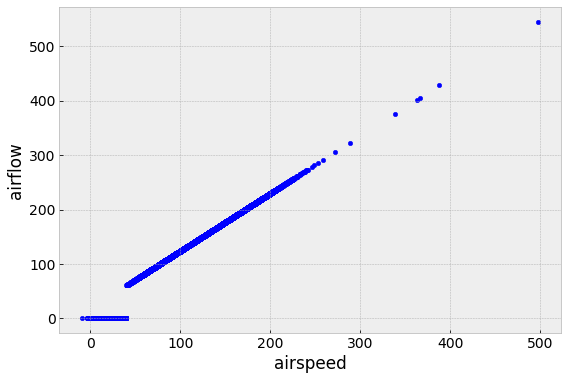

In [12]:
# Compute Air Flow in CFM from calibration data
airflow = 1.0566 * dfd.airspeed + 18.333         # Air flow in cfm from proxy calibration
nonzero_speed = (dfd.airspeed > 40)              # Speed less than 40 fpm counts as zero speed
dfd['airflow'] = airflow * nonzero_speed         # Zero speed means zero flow
dfd.plot(x='airspeed', y='airflow', kind='scatter')

I am not removing any airflow outliers here.

In [13]:
# Calculate Heat Output in Watts

# Constants:
c_p = 0.240 # Specific heat of air in Btu/lb-F
ro = 0.0749   # Density of air (in lb/ft^3) at standard conditions
VHC = c_p*ro  # Volumetric heat capacity of air in Btu/ft^3-F
print(VHC)

dfd['heat_out'] = dfd.airflow * (dfd.t_delivery - dfd.t_return) * VHC * 60 / 3.412

# Eliminate the coil temp column
dfd.drop(columns=['t_coil'], inplace=True)
dfd.describe()

0.017976


,t_out,power,airspeed,t_delivery,t_return,airflow,heat_out
count,1.819915e+06,1.818550e+06,1.819674e+06,1.819915e+06,1.819915e+06,1.819674e+06,1.819674e+06
mean,2.890385e+01,1.150438e+02,1.226483e+01,6.938441e+01,6.660027e+01,1.453934e+01,1.593016e+02
std,1.090487e+01,3.968522e+02,3.794369e+01,1.444734e+01,4.193026e+00,4.539594e+01,6.038603e+02
min,-1.211544e+01,-6.378184e+00,-9.511621e+00,1.628906e+01,1.641421e+01,0.000000e+00,-1.130452e+03
25%,2.335494e+01,4.890676e+00,1.820209e-01,6.417661e+01,6.443917e+01,0.000000e+00,-0.000000e+00
50%,3.124205e+01,5.214241e+00,2.004053e-01,6.547210e+01,6.567928e+01,0.000000e+00,-0.000000e+00
75%,3.633908e+01,5.610726e+00,2.932821e-01,6.723580e+01,6.751149e+01,0.000000e+00,-0.000000e+00
max,6.334097e+01,2.394634e+03,4.978166e+02,1.436833e+02,1.018910e+02,5.443260e+02,4.153383e+03


In [15]:
e_in = dfd.power.sum() * 10./3600/1000
e_out = dfd.heat_out.sum() * 10./3600/1000
print(f'Energy In: {e_in:.1f} kWh')
print(f'Energy Out: {e_out:.1f} kWh')
print(f'COP: {e_out / e_in:.2f}')

Energy In: 581.1 kWh
Energy Out: 805.2 kWh
COP: 1.39


In [16]:
dfd.sum()

t_out         5.260254e+07
power         2.092130e+08
airspeed      2.231800e+07
t_delivery    1.262737e+08
t_return      1.212068e+08
airflow       2.645685e+07
heat_out      2.898770e+08
dtype: float64